### Sequential neural posterior estimation

In [1]:
import numpyro.distributions as ndist
import numpyro
import jax.numpy as jnp
import jax.random as jr
from flowjax.train.data_fit import fit_to_data_sequential

from jax import config
config.update("jax_enable_x64", True)

def model(x_obs=None):
    with numpyro.plate("task_dim", 2):
        theta = numpyro.sample("theta", ndist.Normal(0, 1))
        component = numpyro.sample("c", ndist.Categorical(jnp.array([0.5])), infer={"enumerate": "parallel"})
        scale = jnp.where(component==0, 0.1, 0.5)
        numpyro.sample("x", ndist.Normal(theta, scale), obs=x_obs)

from numpyro.infer import Predictive
key, subkey = jr.split(jr.PRNGKey(0))
x_obs = Predictive(model, num_samples=1)(subkey)["x"][0]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Sample reference posterior using numpyro and MCMC

In [2]:
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import jax.random as jr
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=10000)
key, subkey = jr.split(key)
mcmc.run(subkey, x_obs)
reference_posterior = mcmc.get_samples()["theta"][::10]

sample: 100%|██████████| 11000/11000 [00:04<00:00, 2734.33it/s, 3 steps of size 8.77e-01. acc. prob=0.92]


### Infer approximate posterior using SNPE

In [22]:
key, subkey = jr.split(jr.PRNGKey(0))
prior_predictive_samples = numpyro.infer.Predictive(model, num_samples=1000)(subkey)
theta_dim, x_dim = 2, 2

from flowjax.flows import MaskedAutoregressiveFlow
from flowjax.distributions import Normal, Uniform
from flowjax.bijections import RationalQuadraticSpline
import jax.numpy as jnp
from jax import config

import jax


def simulate(key, theta):
    predictive = numpyro.infer.Predictive(model, {"theta": theta})
    return predictive(key)["x"]

key, subkey = jr.split(key)
proposal = MaskedAutoregressiveFlow(
    subkey,
    base_dist=Normal(jnp.zeros(2)),
    transformer=RationalQuadraticSpline(6, 3, min_derivative=0.01),
    cond_dim=x_dim,
    nn_depth=1
    )

sim_per_round = 1000
prior = Normal(jnp.zeros(theta_dim))  # Matches prior from the model

data = {
    "theta": [],
    "x_sim": []
}

for r in range(2):
    # Carry out simulations (from prior for round 1, the running proposal otherwise).
    key, theta_key, x_key, train_key = jr.split(key, 4)

    if r==0:
        theta_r = prior.sample(theta_key, (sim_per_round, ))
    else: 
        theta_r = proposal.sample(theta_key, (sim_per_round, ), condition=x_obs) # TODO jit?

    x_r = simulate(x_key, theta_r)

    data["theta"].append(theta_r)
    data["x_sim"].append(x_r)

    proposal, losses = fit_to_data_sequential(
        key=train_key,
        proposal=proposal,
        prior=prior,
        theta=jnp.concatenate(data["theta"]),
        x_sim=jnp.concatenate(data["x_sim"]),
        x_obs=x_obs,
        is_first_round=r==0,
        n_contrastive=5,
        learning_rate=1e-4,
        max_epochs=100
        )

key, theta_key = jr.split(key)
data["theta"].append(
    proposal.sample(theta_key, (sim_per_round, ), condition=x_obs)
)


100%|██████████| 100/100 [02:27<00:00,  1.48s/it, train=-3.422839363914077, val=-3.02]


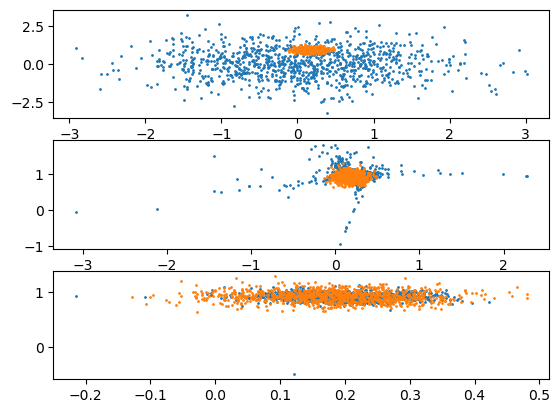

In [26]:
fig, axes = plt.subplots(nrows=len(data["theta"]))

for r, (ax, samps) in enumerate(zip(axes, data["theta"])):
    ax.scatter(samps[:, 0], samps[:, 1], label=r, s=1)
    ax.scatter(reference_posterior[:, 0], reference_posterior[:, 1], s=1)
    title = "Round 0 (prior)" if r==0 else f"Round {r}"
    ax.suptitle()
